In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from pathlib import Path

import torch
import random


## Helper functions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


In [3]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [4]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [5]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'}, annot_kws={'size': 11})

        ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

## Code

In [6]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [7]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

## One Class SVM (Normal data only)



=== Training One-Class SVM with nu=0.0001 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.90  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.98  0.96  0.84	       0.76  0.71  0.74		 0.86  0.82  0.79	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.91  0.74


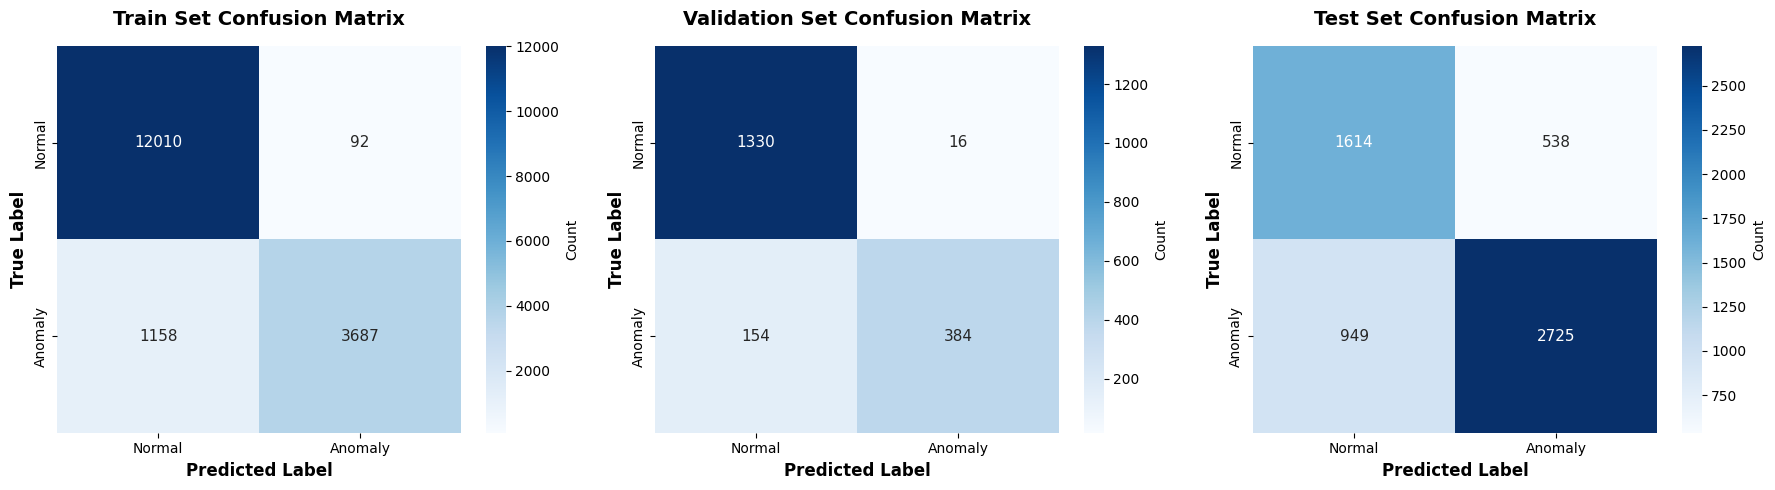



=== Training One-Class SVM with nu=0.001 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.90  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.98  0.96  0.84	       0.76  0.71  0.74		 0.86  0.82  0.78	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.91  0.74


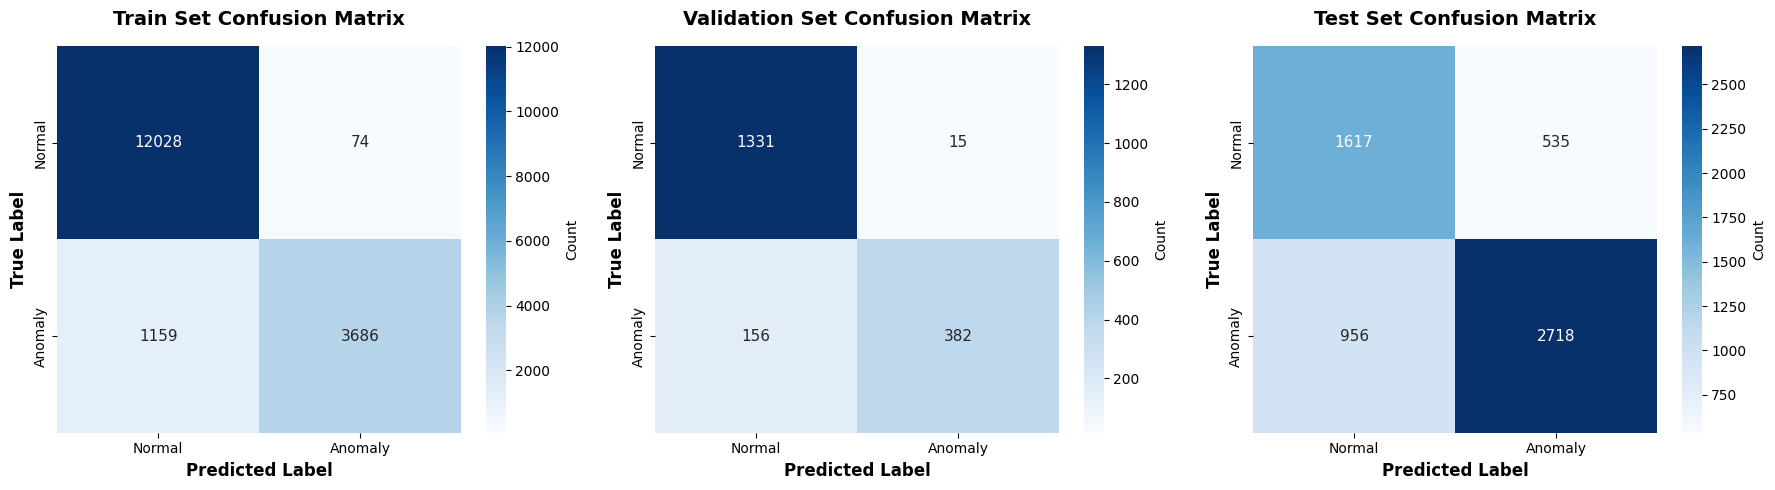



=== Training One-Class SVM with nu=0.5 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.99  0.99  0.76	       0.50  0.50  0.08		 0.66  0.67  0.15	   12102  1346  2152
1                    0.44  0.44  0.65	       0.99  0.99  0.98		 0.61  0.61  0.78	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.64  0.64  0.65


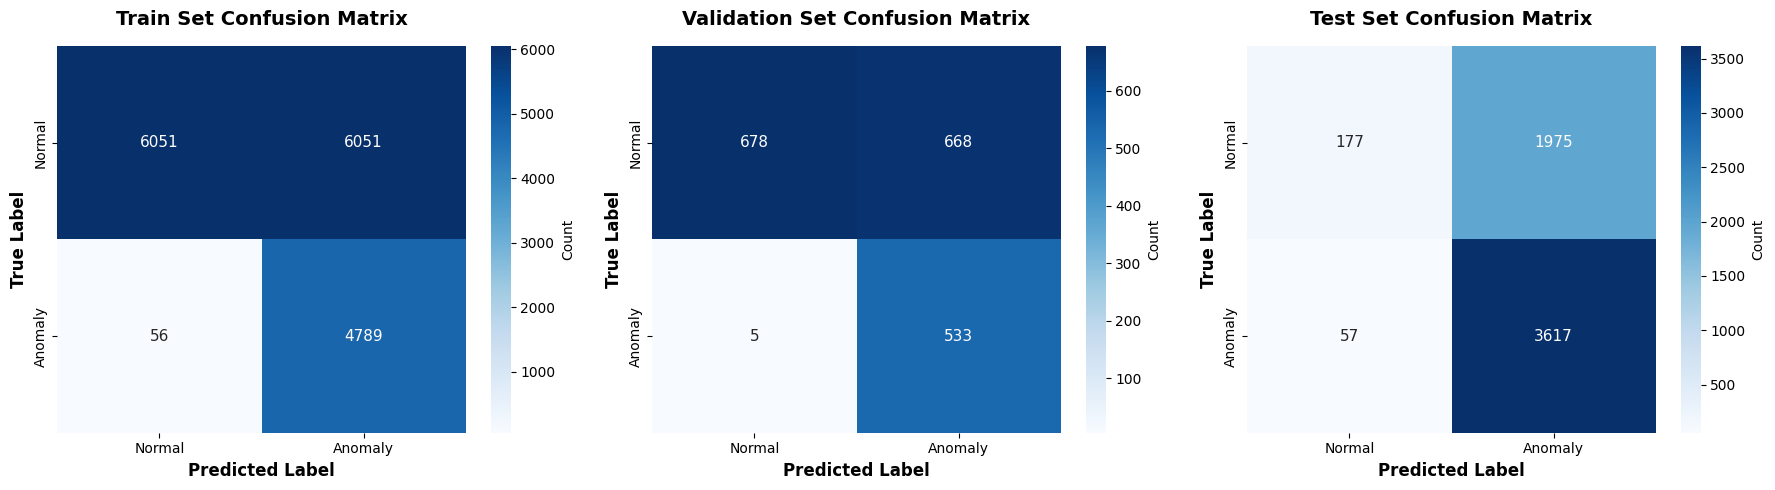

In [13]:
for nu in [0.0001, 0.001, 0.5]:
    print(f"\n\n=== Training One-Class SVM with nu={nu} ===")
    # === 1. Fit One-Class SVM ===
    # Assume X_train is your input data (numpy array or DataFrame with features only)
    ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)  # nu = expected anomaly proportion - only normal data
    ocsvm_normal_only.fit(X_train_normal_only)

    # === 2. Inference ===
    # Predict returns 1 for inliers, -1 for outliers
    # Convert to binary anomaly labels: 1 = anomaly, 0 = normal

    y_train_pred = ocsvm_normal_only.predict(X_train)
    y_train_pred_binary = (y_train_pred == -1).astype(int)


    y_val_pred = ocsvm_normal_only.predict(X_val)
    y_val_pred_binary = (y_val_pred == -1).astype(int)

    y_test_pred = ocsvm_normal_only.predict(X_test)
    y_test_pred_binary = (y_test_pred == -1).astype(int)

    print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
    )

    plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='ocsvm_confusion_matrices.png'
    )

## One Class SVM (With All data)

In [14]:
anomaly_proportion = sum(y_train) / len(y_train)

# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=anomaly_proportion)  # nu = estimated anomaly proportion
ocsvm.fit(X_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.2858913081961409
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [15]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)


CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.85  0.84  0.54	       0.85  0.84  0.60		 0.85  0.84  0.57	   12102  1346  2152
1                    0.63  0.61  0.75	       0.63  0.61  0.71		 0.63  0.61  0.73	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.78  0.67


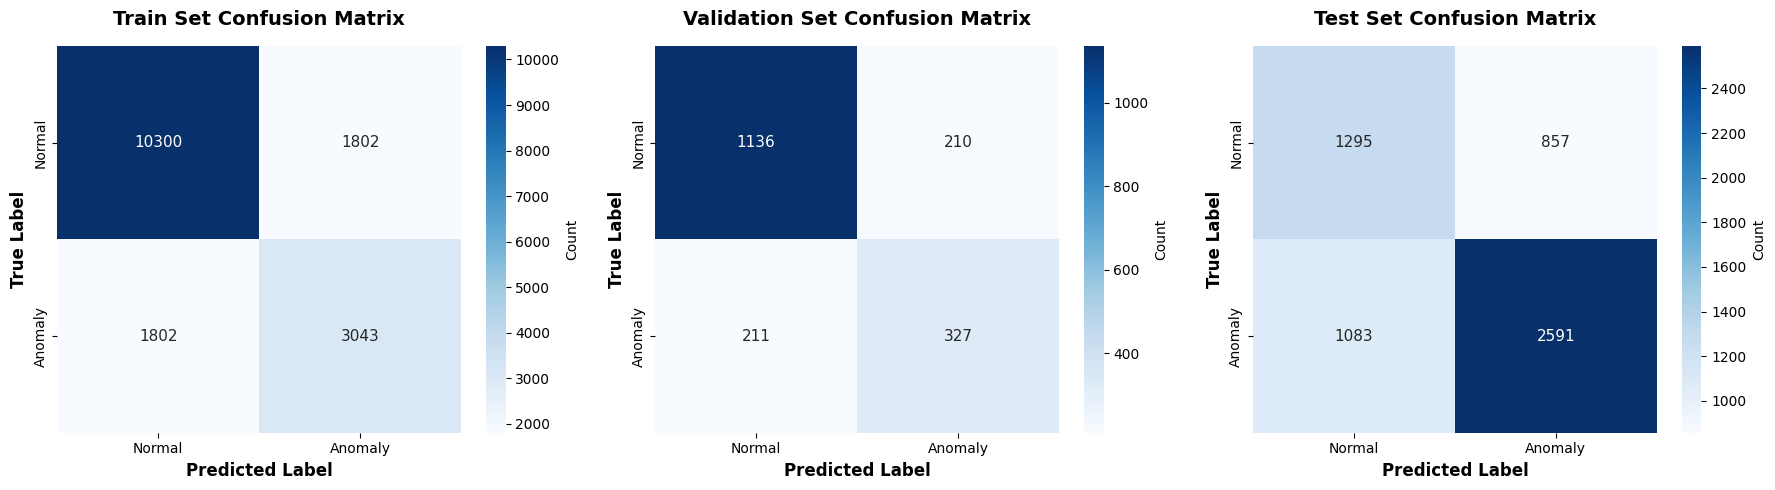

In [16]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='ocsvm_confusion_matrices.png'
)

## One-Class SVM (with normal traffic and some anomalies)

In [24]:
df_train_anomalies_only = df_train[df_train["binary_label"]==1].copy()

In [25]:
df_train_anomalies_only = df_train_anomalies_only.drop(columns=['label', 'binary_label'])

In [26]:
percentages = [0, 0.1, 0.2, 0.5, 1.0]

for p in percentages:
    print(f"\n\n=== Training One-Class SVM with p={p} proportion of anomalies in training data ===")

    subset = df_train_anomalies_only.sample(frac=p, random_state=42)
    df_train_mixed = pd.concat([df_train_normal_only, subset])

    if p == 0:
        nu = 0.0001  # Small value to avoid nu=0
    else:
        nu = p

    # === 1. Fit One-Class SVM ===
    # Assume X_train is your input data (numpy array or DataFrame with features only)
    ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)  # nu = estimated anomaly proportion
    ocsvm.fit(df_train_mixed)

    # === 2. Inference ===
    # Predict returns 1 for inliers, -1 for outliers
    # Convert to binary anomaly labels: 1 = anomaly, 0 = normal

    y_train_pred = ocsvm.predict(X_train)
    y_train_pred_binary = (y_train_pred == -1).astype(int)


    y_val_pred = ocsvm.predict(X_val)
    y_val_pred_binary = (y_val_pred == -1).astype(int)

    y_test_pred = ocsvm.predict(X_test)
    y_test_pred_binary = (y_test_pred == -1).astype(int)

    print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
    )

    plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='ocsvm_confusion_matrices.png'
    )





=== Training One-Class SVM with p=0 proportion of anomalies in training data ===


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- binary_label
- label
